In [211]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [215]:
# Lower bound values for different numbers of stores
# 3: 8.533673716946652
# 5: 7.902133198919353
# 10: 8.296968310182638
# 20: 8.731082080524004
# underage costs = tensor(2.1198, dtype=torch.float64)
# holding costs = tensor(6.6113, dtype=torch.float64)

# 30: 8.37732777290095
# 50: 8.118102268777966

# Create vanilla results dataframe from the provided data
testset_name = "finals_transshipment"

results_interpretor = rri.RayResultsinterpreter()

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']
    if "master" in reference_row:
        out_row["master"] = reference_row["master"]

def default_condition_setter(condition_name):
    return None

# Define color scheme, line styles and markers
color_scheme = {
    128: "#1f77b4",    # Blue
    1024: "#2ca02c",   # Green  
    8192: "#ff7f0e",   # Orange
}

marker_scheme = {
    128: "o",          # Circle
    1024: "v",         # Down triangle
    8192: "s",         # Square
}

linestyle_scheme = {
    "Vanilla": "-",  # Dashed
    "GNN": "--",         # Solid
}
# Define paths for each architecture
# Define architectures with their path patterns
architectures = {
    "Vanilla": lambda n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/vanilla_transshipment_50',
    "GNN": lambda n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_transshipment_50',
}

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'

# Define number of stores and sample sizes
n_stores = [3, 5, 10, 20, 30, 50]
sample_sizes = [128, 1024, 8192]

# Store lower bounds in a dictionary for easy lookup
lower_bounds = {
    3: 8.533673716946652,
    5: 7.902133198919353,
    10: 8.296968310182638,
    20: 8.731082080524004,
    30: 8.37732777290095,
    50: 8.118102268777966,
}

dfs = []

# Create dataframes for each architecture, store size and sample size
for arch_name, path_fn in architectures.items():
    path = path_fn(None)
    df = results_interpretor.make_table(
        {1: path},
        {
            'train_dev_sample_and_batch_size': sample_sizes,
            'store_underage_cost': [9],
            'store_lead_time': [4],
            'samples': [1],
            'n_stores': n_stores
        },
        default_condition_setter, custom_data_filler,
        sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by,
        test_loss_limit=100
    )
    if df.empty:
        continue

    df.insert(2, 'Architecture Class', arch_name)
    df.insert(1, 'hyperparam_name', arch_name)
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)

import numpy as np

test_loss_column = 'Test Loss'
test_loss_filename = 'transshipment_backlogged_5000_test_loss.txt'

test_losses = []
for _, row in df.iterrows():
    test_loss_path = str(row['path']) +"/"+ test_loss_filename
    try:
        with open(test_loss_path, 'r') as f:
            value = float(f.read().strip())
    except Exception:
        value = np.nan
    test_losses.append(value)

df[test_loss_column] = test_losses

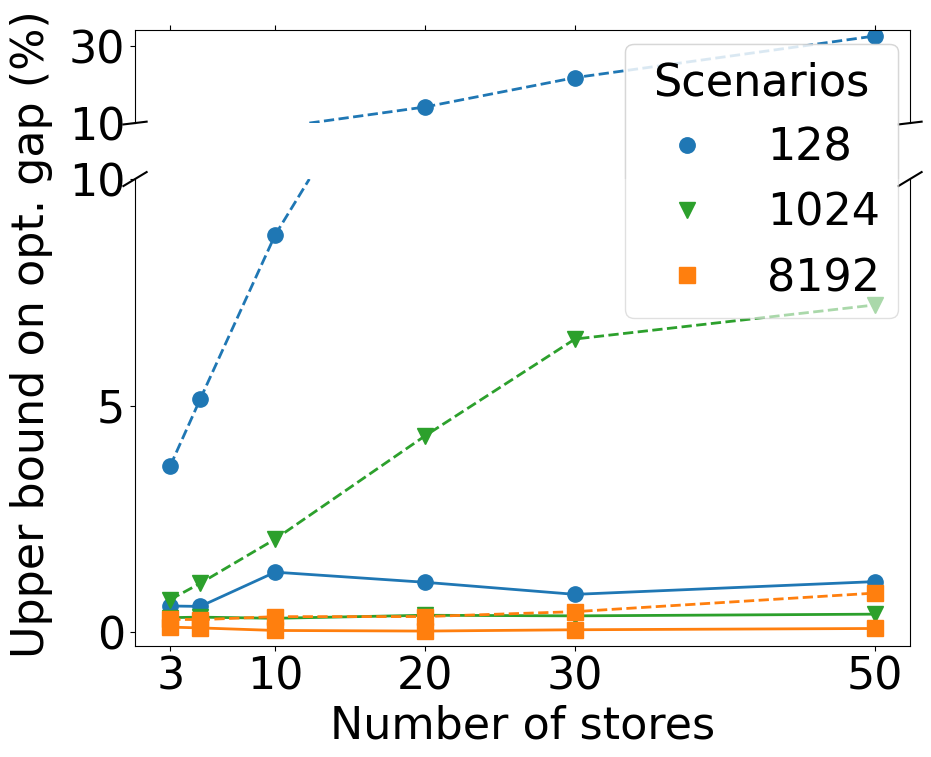

In [232]:
# Calculate optimality gap using lower bounds

sample_marker_map = {
    128: 'o',
    1024: 'v',
    8192: 's',
}
sample_color_map = {
    128: "#1f77b4",
    1024: "#2ca02c",
    8192: "#ff7f0e",
}
arch_linestyle_map = {
    'GNN': '-',
    'Vanilla': '--',
}

df['Architecture Class'] = df['Architecture Class'].replace(
    {'Vanilla NN': 'Vanilla', 'Data-Driven NN': 'Vanilla'}
)

stats_by_arch_sample_and_stores = {}
for n_store in n_stores:
    store_data = df[df['n_stores'] == n_store].copy()
    if store_data.empty:
        continue

    lower_bound = lower_bounds[n_store]
    store_data.loc[:, 'Optimality Gap %'] = ((store_data['Test Loss'] - lower_bound) / lower_bound) * 100

    for arch in store_data['Architecture Class'].unique():
        for sample_size in sample_sizes:
            key = (arch, sample_size)
            if key not in stats_by_arch_sample_and_stores:
                stats_by_arch_sample_and_stores[key] = []

            sample_data = store_data[(store_data['train_dev_sample_and_batch_size'] == sample_size) &
                                     (store_data['Architecture Class'] == arch)]
            if not sample_data.empty:
                gaps = sample_data['Optimality Gap %'].to_numpy()
                mean_gap = np.mean(gaps)
                stats_by_arch_sample_and_stores[key].append({
                    'n_stores': n_store,
                    'mean_gap': mean_gap
                })

FONTSIZE = 32
plt.rcParams.update({'font.size': FONTSIZE})

arch_order = ['GNN', 'Vanilla']
sample_order = [128, 1024, 8192]

fig, (ax1, ax2) = plt.subplots(
    2, 1, 
    sharex=True, 
    figsize=(10, 8), 
    gridspec_kw={'height_ratios': [0.4, 2.0],
                 'hspace': 0.2}
)

# Use variables for the y-break and the transition smoothing
y_break = 10
transition_width = 0.2  # controls how much horizontal space the transition takes

for arch in arch_order:
    for sample_size in sample_order:
        key = (arch, sample_size)
        stats = stats_by_arch_sample_and_stores.get(key, [])
        stats_df = pd.DataFrame(stats)
        if not stats_df.empty:
            n_stores_array = stats_df['n_stores'].to_numpy()
            mean_gap_array = stats_df['mean_gap'].to_numpy()
            # For the blue dashed line (Vanilla, 128), smooth the transition between ax2 and ax1
            if arch == 'Vanilla' and sample_size == 128:
                # Find the index where the transition happens (where mean_gap crosses y_break)
                above = mean_gap_array > y_break
                if np.any(above):
                    first_above_idx = np.argmax(above)
                    if first_above_idx > 0:
                        # Interpolate a transition point at y_break
                        x0, y0 = n_stores_array[first_above_idx - 1], mean_gap_array[first_above_idx - 1]
                        x1, y1 = n_stores_array[first_above_idx], mean_gap_array[first_above_idx]
                        # Linear interpolation for x at y_break
                        if y1 != y0:
                            x_transition = x0 + (x1 - x0) * (y_break - y0) / (y1 - y0)
                        else:
                            x_transition = (x0 + x1) / 2
                        # Insert the transition point
                        n_stores_ax2 = np.append(n_stores_array[:first_above_idx], x_transition)
                        mean_gap_ax2 = np.append(mean_gap_array[:first_above_idx], y_break)
                        n_stores_ax1 = np.insert(n_stores_array[first_above_idx:], 0, x_transition)
                        mean_gap_ax1 = np.insert(mean_gap_array[first_above_idx:], 0, y_break)
                        # Plot on ax2 (bottom) - plot up to transition with markers, then transition segment without marker
                        ax2.plot(
                            n_stores_array[:first_above_idx], mean_gap_array[:first_above_idx],
                            marker=sample_marker_map[sample_size],
                            color=sample_color_map[sample_size],
                            linestyle=arch_linestyle_map[arch],
                            markersize=11,
                            linewidth=2,
                            label=f"{arch}, {sample_size}"
                        )
                        ax2.plot(
                            [n_stores_array[first_above_idx - 1], x_transition],
                            [mean_gap_array[first_above_idx - 1], y_break],
                            color=sample_color_map[sample_size],
                            linestyle=arch_linestyle_map[arch],
                            linewidth=2,
                        )
                        # Plot on ax1 (top) - transition segment without marker, then from transition with markers
                        ax1.plot(
                            [x_transition, n_stores_array[first_above_idx]],
                            [y_break, mean_gap_array[first_above_idx]],
                            color=sample_color_map[sample_size],
                            linestyle=arch_linestyle_map[arch],
                            linewidth=2,
                        )
                        ax1.plot(
                            n_stores_array[first_above_idx:], mean_gap_array[first_above_idx:],
                            marker=sample_marker_map[sample_size],
                            color=sample_color_map[sample_size],
                            linestyle=arch_linestyle_map[arch],
                            markersize=11,
                            linewidth=2,
                            label=f"{arch}, {sample_size}"
                        )
                        continue  # skip the default plotting below for this line
            # Default plotting for all other lines
            ax1.plot(
                n_stores_array, mean_gap_array,
                marker=sample_marker_map[sample_size],
                color=sample_color_map[sample_size],
                linestyle=arch_linestyle_map[arch],
                markersize=11,
                linewidth=2,
                label=f"{arch}, {sample_size}"
            )
            ax2.plot(
                n_stores_array, mean_gap_array,
                marker=sample_marker_map[sample_size],
                color=sample_color_map[sample_size],
                linestyle=arch_linestyle_map[arch],
                markersize=11,
                linewidth=2,
                label=f"{arch}, {sample_size}"
            )

arch_lines = [
    plt.Line2D([0], [0], color='black', linestyle=arch_linestyle_map[arch], label=arch, linewidth=2)
    for arch in arch_order
]
sample_patches = [
    plt.Line2D([0], [0], color=sample_color_map[size], marker=sample_marker_map[size],
               linestyle='none', label=f'{size}', markersize=11)
    for size in sample_order
]

ax2.set_xlabel('Number of stores', fontsize=FONTSIZE)
fig.supylabel('Upper bound on opt. gap (%)', fontsize=FONTSIZE, x=0)

# legend1 = ax1.legend(handles=arch_lines,
#                      bbox_to_anchor=(0.99, 0.2),
#                      loc='upper right',
#                      fontsize=FONTSIZE,
#                      borderaxespad=0.1,
#                      framealpha=0.6
#                     )
# fig.add_artist(legend1)

legend2 = ax1.legend(handles=sample_patches,
                     title='Scenarios',
                    #  bbox_to_anchor=(0.01, 1),
                    #  loc='upper left',
                     bbox_to_anchor=(0.99, 0.9),
                     loc='upper right',
                     fontsize=FONTSIZE,
                     borderaxespad=0.1,
                     framealpha=0.6
                    )
fig.add_artist(legend2)
legend2.get_title().set_fontsize(FONTSIZE)

xtick_values = [3, 10, 20, 30, 50]
ax2.set_xticks(xtick_values)
ax2.set_xticklabels([str(x) for x in xtick_values], fontsize=FONTSIZE)

ax1_ytick_values = [10, 30]
ax1.set_yticks(ax1_ytick_values)
ax1.set_yticklabels([str(y) for y in ax1_ytick_values], fontsize=FONTSIZE)

ax1.tick_params(axis='y', labelsize=FONTSIZE)
ax2.tick_params(axis='y', labelsize=FONTSIZE)

ax1.set_ylim(y_break, None)
ax2.set_ylim(-0.3, y_break)

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)
ax2.xaxis.tick_bottom()

ax2_ytick_values = [0, 5, 10]
ax2.set_yticks(ax2_ytick_values)
ax2.set_yticklabels([str(y) for y in ax2_ytick_values], fontsize=FONTSIZE)

d = .015
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

plt.savefig('/user/ml4723/Prj/NIC/Plots/sample_efficiency_transshipment.pdf', bbox_inches='tight')
plt.show()

In [217]:
lower_bounds = {
    3: 8.533673716946652,
    5: 7.902133198919353,
    10: 8.296968310182638,
    20: 8.731082080524004,
    30: 8.37732777290095,
    50: 8.118102268777966,
}

# Prepare mapping for architecture class sorting
arch_sort_map = {'GNN': 0, 'Vanilla': 1}

# Prepare the new DataFrame
def get_value(row, col):
    return row[col] if col in row and pd.notnull(row[col]) else '-'

def format_loss(val):
    return '-' if val == '-' or pd.isnull(val) else round(val, 2)

def format_gap(val):
    return '-' if val == '-' or pd.isnull(val) else round(val, 2)

# Copy and preprocess df
df_table = df.copy()

# Rename Architecture Class
df_table['Architecture Class'] = df_table['Architecture Class'].replace('Vanilla NN', 'Vanilla')

# Calculate upper bound on test opt. gap (%)
def calc_gap(row):
    n = row['n_stores']
    test_loss = row['Test Loss']
    if pd.isnull(test_loss) or n not in lower_bounds or pd.isnull(lower_bounds[n]):
        return '-'
    lb = lower_bounds[n]
    return round(((test_loss - lb) / lb) * 100, 2)

df_table['Upper bound on test opt. gap (%)'] = df_table.apply(calc_gap, axis=1)

# Prepare output columns
output_cols = [
    ('Number of stores', 'n_stores'),
    ('Training scenarios (#)', 'train_dev_sample_and_batch_size'),
    ('Architecture Class', 'Architecture Class'),
    ('Learning rate', 'Learning Rate'),
    ('Units per layer (#)', 'master'),
    ('Train loss', 'Train Loss'),
    ('Dev loss', 'Dev Loss'),
    ('Test loss', 'Test Loss'),
    ('Upper bound on test opt. gap (%)', 'Upper bound on test opt. gap (%)')
]

# Build the output DataFrame
table_rows = []
for idx, row in df_table.iterrows():
    out_row = []
    for col_name, col_key in output_cols:
        val = get_value(row, col_key)
        if col_name in ['Train loss', 'Dev loss', 'Test loss']:
            val = format_loss(val)
        elif col_name == 'Upper bound on test opt. gap (%)':
            val = format_gap(val)
        out_row.append(val)
    table_rows.append(out_row)

table_df = pd.DataFrame(table_rows, columns=[col[0] for col in output_cols])

# Sort by Number of stores, Training scenarios, Architecture Class (GNN first, then Vanilla)
def arch_sorter(arch):
    return arch_sort_map.get(arch, 99)

table_df['arch_sort'] = table_df['Architecture Class'].apply(arch_sorter)
table_df = table_df.sort_values(
    by=['Number of stores', 'Training scenarios (#)', 'arch_sort'],
    ascending=[True, True, True]
).reset_index(drop=True)
table_df = table_df.drop(columns=['arch_sort'])

# For each Number of stores, bold the Test loss with lowest relative test loss
def bold_best_test_loss(group):
    # Only consider rows with numeric test loss and lower bound
    best_idx = None
    best_rel = None
    n = group['Number of stores'].iloc[0]
    lb = lower_bounds.get(n, None)
    for idx, row in group.iterrows():
        try:
            test_loss = float(row['Test loss'])
            if lb is not None and lb > 0:
                rel = (test_loss - lb) / lb
                if (best_rel is None) or (rel < best_rel):
                    best_rel = rel
                    best_idx = idx
        except:
            continue
    if best_idx is not None:
        val = group.at[best_idx, 'Test loss']
        group.at[best_idx, 'Test loss'] = r'\textbf{' + str(val) + '}'
    return group

table_df = table_df.groupby('Number of stores', group_keys=False).apply(bold_best_test_loss)

print(table_df.to_string(index=False))

 Number of stores  Training scenarios (#) Architecture Class  Learning rate Units per layer (#)  Train loss  Dev loss     Test loss  Upper bound on test opt. gap (%)
                3                     128                GNN         0.0010                   -        8.60      8.54          8.58                              0.58
                3                     128            Vanilla         0.0010               256.0        8.46      8.81          8.85                              3.67
                3                    1024                GNN         0.0010                   -        8.71      8.54          8.56                              0.32
                3                    1024            Vanilla         0.0010               256.0        8.67      8.58          8.59                              0.72
                3                    8192                GNN         0.0010                   -        8.55      8.52 \textbf{8.54}                              0.11
    

/var/folders/s0/h372zwws2xl0yflc5w4m85j00000gn/T/ipykernel_93846/102625652.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textbf{8.54}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  group.at[best_idx, 'Test loss'] = r'\textbf{' + str(val) + '}'
/var/folders/s0/h372zwws2xl0yflc5w4m85j00000gn/T/ipykernel_93846/102625652.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textbf{7.91}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  group.at[best_idx, 'Test loss'] = r'\textbf{' + str(val) + '}'
/var/folders/s0/h372zwws2xl0yflc5w4m85j00000gn/T/ipykernel_93846/102625652.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textbf{8.3}' has dtype incom

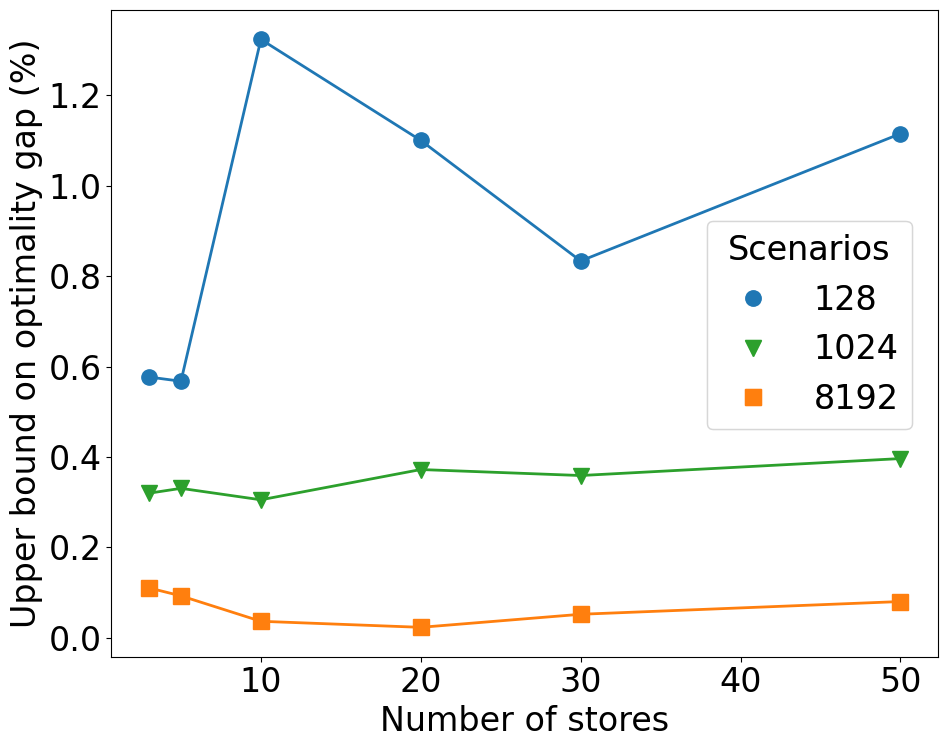

In [225]:
# Calculate optimality gap using lower bounds
stats_by_arch_sample_and_stores = {}
for n_store in n_stores:
    store_data = df[df['n_stores'] == n_store].copy()
    if store_data.empty:
        continue

    lower_bound = lower_bounds[n_store]
    store_data.loc[:, 'Optimality Gap %'] = ((store_data['Test Loss'] - lower_bound) / lower_bound) * 100

    # Remove 'Vanilla NN' from architectures
    filtered_archs = [arch for arch in store_data['Architecture Class'].unique() if arch != 'Vanilla']
    for arch in filtered_archs:
        for sample_size in sample_sizes:
            key = (arch, sample_size)
            if key not in stats_by_arch_sample_and_stores:
                stats_by_arch_sample_and_stores[key] = []

            sample_data = store_data[(store_data['train_dev_sample_and_batch_size'] == sample_size) &
                                     (store_data['Architecture Class'] == arch)]
            if not sample_data.empty:
                gaps = sample_data['Optimality Gap %'].to_numpy()
                mean_gap = np.mean(gaps)
                stats_by_arch_sample_and_stores[key].append({
                    'n_stores': n_store,
                    'mean_gap': mean_gap
                })

FONTSIZE = 24
MARKERSIZE = 11
LINEWIDTH = 2
plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': FONTSIZE})

for (arch, sample_size), stats in stats_by_arch_sample_and_stores.items():
    stats_df = pd.DataFrame(stats)
    if not stats_df.empty:
        n_stores_array = stats_df['n_stores'].to_numpy()
        mean_gap_array = stats_df['mean_gap'].to_numpy()

        # Use solid line for GNN, otherwise use the original linestyle
        if arch == 'GNN':
            linestyle = '-'
        else:
            linestyle = linestyle_scheme[arch]

        plt.plot(
            n_stores_array,
            mean_gap_array,
            marker=marker_scheme[sample_size],
            color=color_scheme[sample_size],
            linestyle=linestyle,
            markersize=MARKERSIZE,
            linewidth=LINEWIDTH
        )

sample_patches = [
    plt.Line2D(
        [0], [0],
        color=color_scheme[size],
        marker=marker_scheme[size],
        linestyle='none',
        label=f'{size}',
        markersize=MARKERSIZE
    )
    for size in color_scheme.keys()
]

plt.xlabel('Number of stores', fontsize=FONTSIZE)
plt.ylabel('Upper bound on optimality gap (%)', fontsize=FONTSIZE)

legend2 = plt.legend(
    handles=sample_patches,
    bbox_to_anchor=(0.7, 0.7),
    loc='upper left',
    fontsize=FONTSIZE,
    framealpha=0.6,
    title="Scenarios"
)
plt.gca().add_artist(legend2)
legend2.get_title().set_fontsize(FONTSIZE)

plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.tight_layout()
plt.savefig('/user/ml4723/Prj/NIC/Plots/optimality_transshipment_GNN.pdf', bbox_inches='tight')
plt.show()

In [17]:
df_table = df
columns_to_remove = [
    '# of stores',
    'hyperparam_name',
    # 'Architecture Class',
    'store_underage_cost',
    'store_lead_time',
    'samples',
    'config',
    'path',
    'Learning Rate'
]
df_table = df_table.drop(columns=[col for col in columns_to_remove if col in df_table.columns])

# Lower bounds for transshipment (update these as appropriate for your transshipment experiment)
transshipment_lower_bounds = {
    3: 8.533673716946652,
    5: 7.902133198919353,
    10: 8.296968310182638,
    20: 8.731082080524004,
    30: 8.37732777290095,
    50: 8.118102268777966,
}

def get_transshipment_gap(row):
    n_stores = row['n_stores']
    lower_bound = transshipment_lower_bounds.get(n_stores, None)
    if lower_bound is not None:
        return (row['Test Loss'] - lower_bound) / lower_bound * 100
    else:
        return None

df_table['Test Loss Gap'] = df_table.apply(get_transshipment_gap, axis=1)

df_table = df_table[df_table["Architecture Class"] != 'Vanilla NN']

sample_sizes = [128, 1024, 8192]
summary_rows = []
for sample_size in sample_sizes:
    subset = df_table[df_table['train_dev_sample_and_batch_size'] == sample_size]
    avg_gap = subset['Test Loss Gap'].mean()
    min_gap = subset['Test Loss Gap'].min()
    max_gap = subset['Test Loss Gap'].max()
    summary_rows.append({
        'Sample Size': sample_size,
        'Avgerage opt. gap': avg_gap,
        'Max opt. gap': max_gap
    })
summary_df = pd.DataFrame(summary_rows)
summary_df


,Sample Size,Avgerage opt. gap,Max opt. gap
0,128,0.919409,1.323427
1,1024,0.347365,0.396578
2,8192,0.066105,0.110593


In [5]:
mode = "test"
setting_names = ['transshipment_backlogged_5000']

models = []
for _, row in df.iterrows():
    models.append(str(row['path']) + '/model.pt')

gpus = [0, 1, 2, 4, 5, 6]

def run_main_run(model_path, setting_name, gpu_idx):
    try:
        # Extract hyperparam name from model path
        hyperparam_name = model_path.split('/')[7]
        print(f"Running main_run.py for path {model_path}")
        cmd = [
            "/user/ml4723/.conda/envs/neural_inventory_control/bin/python",
            "main_run.py",
            mode, # test or test_on_dev
            setting_name,
            hyperparam_name,
            str(model_path),
            str(gpus[gpu_idx])
        ]
        env = {
            **os.environ,
            "MKL_THREADING_LAYER": "GNU",
            "MKL_SERVICE_FORCE_INTEL": "1"
        }
        subprocess.run(cmd, capture_output=True, text=True, check=True, env=env, cwd="/user/ml4723/Prj/NIC/")
    except subprocess.CalledProcessError as e:
        print(f"Error running main_run.py for path {model_path}: {e}")
        print(f"Error output: {e.stderr}")
    except Exception as e:
        print(f"Unexpected error running main_run.py for path {model_path}: {e}")

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = []
    gpu_idx = 0
    for setting_name in setting_names:
        for path in models:
            while len(futures) >= 6*len(gpus):
                done, not_done = concurrent.futures.wait(
                    futures, 
                    return_when=concurrent.futures.FIRST_COMPLETED
                )
                futures = list(not_done)
            futures.append(executor.submit(run_main_run, path, setting_name, gpu_idx))
            gpu_idx = (gpu_idx + 1) % len(gpus)
    concurrent.futures.wait(futures)


Running main_run.py for path /Users/minuk.lee/Downloads/Neural_inventory_control/ray_results/finals_transshipment/vanilla_transshipment_50/run_2025-05-21_11-36-07/run_5033a_00427_427_config=transshipment_backlogged,dev_ignore_periods=60,dev_periods=100,different_for_each_sample=True,early_sto_2025-05-21_13-56-35/model.pt
Running main_run.py for path /Users/minuk.lee/Downloads/Neural_inventory_control/ray_results/finals_transshipment/vanilla_transshipment_50/run_2025-05-21_11-36-07/run_5033a_00319_319_config=transshipment_backlogged,dev_ignore_periods=60,dev_periods=100,different_for_each_sample=True,early_sto_2025-05-21_11-39-44/model.pt
Running main_run.py for path /Users/minuk.lee/Downloads/Neural_inventory_control/ray_results/finals_transshipment/vanilla_transshipment_50/run_2025-05-21_11-36-07/run_5033a_00106_106_config=transshipment_backlogged,dev_ignore_periods=60,dev_periods=100,different_for_each_sample=True,early_sto_2025-05-21_11-36-12/model.pt
Running main_run.py for path /U